In [1]:
## GPs regression
import numpy as np
from numpy.linalg import inv, cholesky
import matplotlib.pyplot as plt
plt.style.use('classic')


class GP(object):
    def __init__(self, length=1.0, sigma_f=1.0, sigma_n=0.5):
        self.length, self.sigma_f, self.sigma_n = length, sigma_f, sigma_n
        self.X_train, self.L, self.L_inv, self.alpha = None, None, None, None

    ## Kernel function
    def rbf_kernel(self, x, y):
        return self.sigma_f ** 2 * np.exp(-(x - y) ** 2 / (2 * self.length ** 2)) + self.sigma_n ** 2 * (x == y)

    def train(self, X_train, Y_train):
        ## Compute the Gram matrix K
        # mu_* = k_*^T K^-1 y = k_*^T alpha
        self.X_train = X_train
        n_train = len(X_train)
        K = np.array([self.rbf_kernel(x, y) for x in X_train for y in X_train]).reshape((n_train, n_train))
        # do the cholesky decomposition 
        L = cholesky(K)
        self.L, self.L_inv = L, inv(L)
        self.alpha = inv(self.L.T).dot(self.L_inv.dot(Y_train))  # L.T \ ( L \ Y_train )

    def make_prediction(self, X_test):
        # mu_* = k_*^T K^-1 y = k_*^T alpha
        # sigma_* = k(x_*, x_*) - k_*^T K^-1 k_*
        if self.X_train is not None:
            n_train, n_test = len(self.X_train), len(X_test)
            # calculate the kernel value for each test point with each trainings point
            K_star = np.array([self.rbf_kernel(x, y) for x in X_train for y in X_test]).reshape((n_train, n_test))

            # calculate the kernel value for each test point with every other test point
            K_starstar = np.array([self.rbf_kernel(x, y) for x in X_test for y in X_test]).reshape((n_test, n_test))

            # here self.alpha is K^-1 y
            Y_test = K_star.T.dot(self.alpha)

            v = self.L_inv.dot(K_star)

            V_star = K_starstar - v.T.dot(v)  # = Kstarstar - K_star'*inv(K)*K_star

            std_test = np.diag(V_star)

            return Y_test, std_test
        else:
            print("The gp has not been trained!")
            return 0, 0


In [2]:
# Setup of our trainings data

sigma_noise = 0.5
x_min, x_max = -5, 5
X_train = np.linspace(x_min, x_max, num=10)
# Simulate sinusoid with some gaussian noise
Y_train = [10 * np.sin(x) + (np.random.rand() - 0.5) * sigma_noise for x in X_train]

# Test data
X_test = np.arange(x_min, x_max, step=0.1)

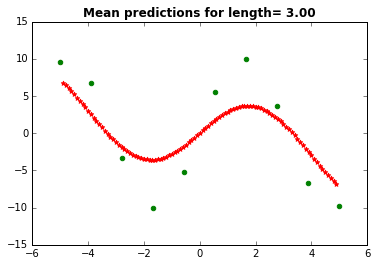

In [5]:
length = 3.0
gp = GP(length=length, sigma_f=1.0, sigma_n=0.5)

gp.train(X_train, Y_train)

Y_test, std_test = gp.make_prediction(X_test)

def plot_mean(X_test, Y_test, X_train, Y_train, length):
    # plot the mean prediction and the training data points
    plt.title('GP regression, varying length scale')
    plt.axis('auto')
    plt.scatter(X_test, Y_test, color='r', marker='*', label='mean predictions')
    plt.scatter(X_train, Y_train, color='g', marker='o', label='training data')
    plt.title('Mean predictions for length={:5.2f}'.format(length), fontweight='bold')

def plot_mean_with_var(X_test, Y_test, X_train, Y_train, std_test):
    plt.axis('auto')
    # Plot predictions
    plt.fill_between(X_test, Y_test - 3 * std_test, Y_test + 3 * std_test, facecolor='lightblue', interpolate=True)
    plt.plot(X_test, Y_test, '-r', label='mean')
    plt.plot(X_test, Y_test + 3 * std_test, '-b', label='+3std')
    plt.plot(X_test, Y_test - 3 * std_test, '-b', label='-3std')
    plt.scatter(X_train, Y_train, color='g', marker='o', label='training data')

plot_mean(X_test, Y_test, X_train, Y_train, length)

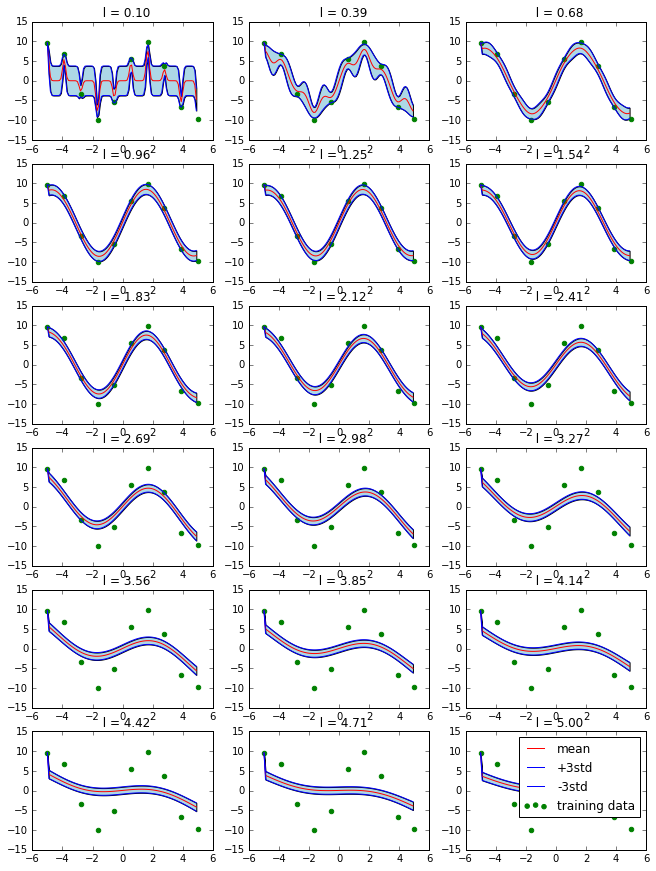

In [10]:
length = 3.0
gp = GP(length=length, sigma_f=1.0, sigma_n=0.5)

gp.train(X_train, Y_train)

Y_test, std_test = gp.make_prediction(X_test)

amount = 18
l_values = np.linspace(0.1, 5.0, num=amount)
s_values = np.linspace(0.1, 2.0, num=amount)
nPlotCols = 3
nPlotRows = np.ceil((len(l_values) + 1) / nPlotCols)
plt.figure(figsize=(11, 11))
plt.subplots_adjust(top=1.35)
for i, length in enumerate(l_values):
    gp = GP(length=length, sigma_f=1.0, sigma_n=0.5)


    gp.train(X_train, Y_train)

    Y_test, std_test = gp.make_prediction(X_test)

    plt.subplot(nPlotRows, nPlotCols, i + 1)
    plt.title('  l = {:.2f}'.format(length))
    plot_mean_with_var(X_test, Y_test, X_train, Y_train, std_test)

plt.legend()
plt.show()

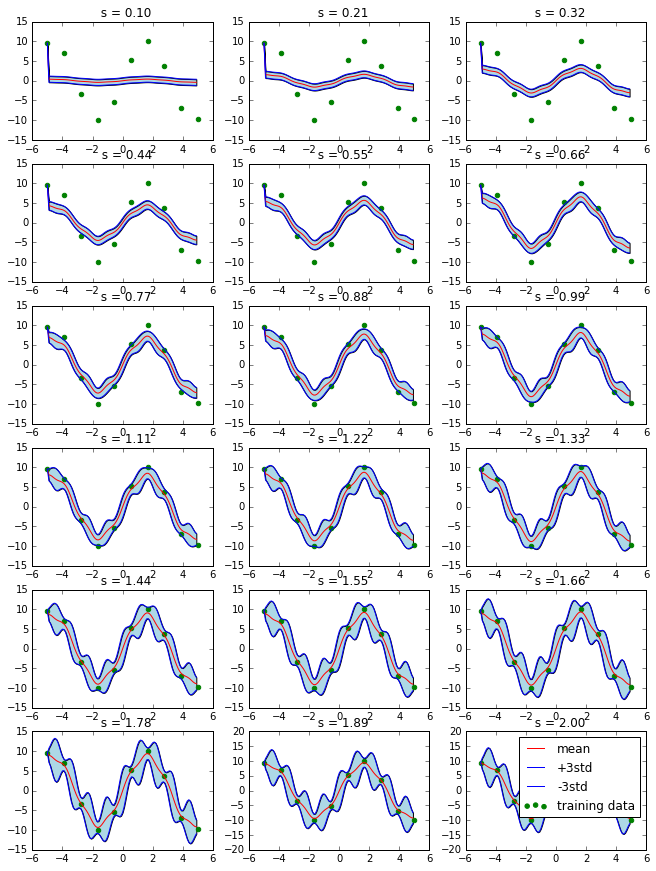

In [ ]:
## for sigma:

gp = GP(length=0.5, sigma_f=1.0, sigma_n=0.5)

gp.train(X_train, Y_train)

Y_test, std_test = gp.make_prediction(X_test)

plt.figure(figsize=(11,11))
plt.subplots_adjust(top=1.35)

for i, sigma_f in enumerate(s_values):
    gp = GP(length=0.5, sigma_f=sigma_f, sigma_n=0.5)

    gp.train(X_train, Y_train)

    Y_test, std_test = gp.make_prediction(X_test)
    
    plt.subplot(nPlotRows, nPlotCols, i + 1)
    plt.title('  s = {:.2f}'.format(sigma_f))
    plot_mean_with_var(X_test, Y_test, X_train, Y_train, std_test)

plt.legend()
plt.show()